In [ ]:
!pip install transformers
!pip install scipy
!pip install torch torchvision 
!pip install matplotlib
# Runtime might need restarting after this installation.
!pip install tdqm
!pip install seaborn
!pip install scikit-posthocs
!pip install twitscrape
# twitscrape is a package I created as an aside to this project to further bolster my learning (https://github.com/christywastaken/twitscrape, https://pypi.org/project/twitscrape). 
# I'm sure there are more effective ways of collecting the tweet data used in this project. If you are looking to repeat this data analysis I would reccomend looking for another package such as snscrape.

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import sqlite3

class SQLContextManager():
    """ Context manager for SQL db """
    def __init__(self, host):
        self.connection = None
        self.host = host

    def __enter__(self):
        self.connection = sqlite3.connect(self.host)
        return self.connection
        
    def __exit__(self, exc_type, exc_val, exc_tab):
        self.connection.commit()
        self.connection.close()
        
        

In [60]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import logging
from scipy.special import softmax
import numpy as np
from tqdm.auto import tqdm

#TODO: Check licensing and citing for https://github.com/cardiffnlp/timelms 
#TODO: consider saving model to local.
#TODO: leave as class or not?

class SentimentAnalysis():
    
    def __init__(self):
        logging.set_verbosity_error()
        self.MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.config = AutoConfig.from_pretrained(self.MODEL)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.MODEL)
        

    def preprocess(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)


    def analyse_sentiment(self, tweet_df: pd.DataFrame) -> pd.DataFrame:
        """ Analyses the sentiment of tweets and returns a dataframe with new columns 'negative', 'neutral' and 'positive' """
        print('Running sentiment analysis. This could take a while.')
        tweet_df_copy = tweet_df.copy()
        # model.save_pretrained(MODEL) #TODO: consider saving to local
        for index, row in tqdm(tweet_df_copy.iterrows(), total=tweet_df_copy.shape[0]):
            try:
                tweet_text = row['tweet_text']
                tweet_text = self.preprocess(tweet_text)
                encoded_input = self.tokenizer(tweet_text, return_tensors='pt')
                output = self.model(**encoded_input)
                scores = output[0][0].detach().numpy()
                scores = softmax(scores)
                scores = np.round(scores.astype(float), 4)
                sentiment_dict = {self.config.id2label[i]: score for i, score in enumerate(scores)}
                for column, value in sentiment_dict.items():
                    tweet_df_copy.at[index, column] = value
                # print(f'tweet: {tweet_text} | senti: {sentiment_dict}')
            except Exception as err:
                print(f'Error at index:{index} | Error: {err}')
        return tweet_df_copy

    


/Users/christianharrison/Documents/Code/learn/purple-beard/capstone/sentiment_analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd
from datetime import datetime

def add_epoch_time_and_sort(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds epoch_seconds column to df and sorts by epoch_seconds ascending """
    
    tweet_df_copy = tweet_df.copy()
    date_format = "%a %b %d %H:%M:%S %z %Y"

    for index, row in tweet_df_copy.iterrows():
        try:
            created_at = row['created_at']
            epoch_seconds = datetime.strptime(created_at, date_format).timestamp()
            tweet_df_copy.at[index, 'epoch_seconds'] = epoch_seconds
        except Exception as err:
            print(f'Error: {err}')
    tweet_df_copy.sort_values(by='epoch_seconds', inplace=True, ignore_index=True)
    tweet_df_copy.reset_index(inplace=True, drop=True)
    return tweet_df_copy


In [42]:
# Testing whether data is missing
import pandas as pd

def check_gaps_in_data(tweet_df: pd.DataFrame) -> pd.DataFrame:
    """ Adds time_diff_mins coloumn to df which can be used for identifying holes in data. This column is the time betweent the current and next tweet """
    tweet_df_copy = tweet_df.copy()
    
    largest_time_diff = 0.0
    index_largest_diff = 0
    for index, row in tweet_df_copy.iterrows():
        try:
            epoch_seconds1 = tweet_df_copy.iloc[index]['epoch_seconds']
            epoch_seconds2 = tweet_df_copy.iloc[index+1]['epoch_seconds']
            
            time_diff = epoch_seconds2 - epoch_seconds1
            time_diff_mins = round((time_diff / 60), 2)
            if time_diff_mins > largest_time_diff:
                largest_time_diff = time_diff_mins
                index_largest_diff = index
            tweet_df_copy.at[index, 'time_diff_mins'] = time_diff_mins
            

        except Exception as err:
            print(f'Error: {err}')
    print(f'-- The largest gap in data is: {largest_time_diff} mins at index: {index_largest_diff} --')
    return tweet_df_copy






In [ ]:

from twitscrape.twitter_scraper import TwitterGeolocationScraper 
# twitscrape is a package I built and distributed as an aside, learning experiment to this project. I plan to work on it further so the import method might change from the above.
# Source code included in twitter_scraper.py 
# https://github.com/christywastaken/twitscrape 
# https://pypi.org/project/twitscrape/ 

newcastle_latitude = 54.975029
newcastle_longitude = -1.612477
search_radius_km = 15.0
twitter_scraper = TwitterGeolocationScraper(start_date='2020-01-01', end_date='2021-01-01', latitude=newcastle_latitude, longitude=newcastle_longitude, radius=search_radius_km, filter_links=True, filter_replies=True, is_headless=True)
tweet_df_2020 = twitter_scraper.run()
# Creates dataframe of all the tweets in Newcastle-Upon-Tyne for a 15km radius for all of 2020. No replies or tweets containing media included.

#Store DF to SQL DB
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    tweet_df_2020.to_sql('all_2020', connection, if_exists='replace', index=False)




In [11]:
# Add epoch_seconds to SQL db.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020"
    tweet_df_2020 = pd.read_sql(query, connection)
    epoc_tweet_df_2020 = add_epoch_time_and_sort(tweet_df=tweet_df_2020)
    epoc_tweet_df_2020.to_sql('all_2020', con=connection, if_exists='replace', index=False)



In [12]:
# check for gaps in data and sort by largest gaps.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020"
    tweet_df_2020 = pd.read_sql(query, connection)

tweet_df_time_gaps_2020 = check_gaps_in_data(tweet_df_2020)
tweet_df_time_gaps_2020.sort_values(by='time_diff_mins', inplace=True, ascending=False)


Error: single positional indexer is out-of-bounds
-- The largest gap in data is: 410.25 mins at index: 31119 --


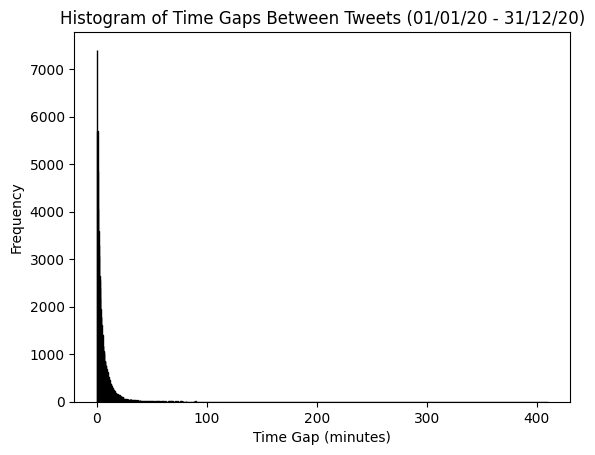

In [41]:
# visiualizing gaps in the data 
import matplotlib.pyplot as plt

plt.hist(tweet_df_time_gaps_2020['time_diff_mins'], bins='auto', edgecolor='black')
plt.title('Histogram of Time Gaps Between Tweets (01/01/20 - 31/12/20)')
plt.xlabel('Time Gap (minutes)')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Getting some numbers on the gaps in the data
data_size = len(tweet_df_time_gaps_2020)
for time in [60,120,360,420,480]:
    num_gaps = sum(tweet_df_time_gaps_2020['time_diff_mins']>time)
    print(f'Percentage of tweets with gap >{str(time)} mins: {round(((num_gaps/data_size)*100),4)}%')


Percentage of tweets with gap >60 mins: 0.8585%
Percentage of tweets with gap >120 mins: 0.2435%
Percentage of tweets with gap >360 mins: 0.0012%
Percentage of tweets with gap >420 mins: 0.0%
Percentage of tweets with gap >480 mins: 0.0%


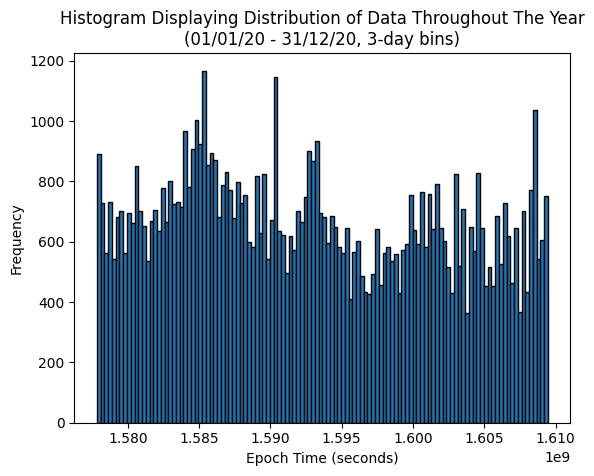

In [44]:
# Visualising spread of data using epoch time in seconds.
plt.hist(tweet_df_time_gaps_2020['epoch_seconds'], bins=120,edgecolor='black')
plt.title('Histogram Displaying Distribution of Data Throughout The Year\n(01/01/20 - 31/12/20, 3-day bins)')
plt.xlabel('Epoch Time (seconds)')
plt.ylabel('Frequency')
plt.show()

In [101]:
# analyse the sentiment of the data. 
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020"
    tweet_df_2020 = pd.read_sql(query, connection)
    sentiment_tweet_df_2020 = SentimentAnalysis().analyse_sentiment(tweet_df=tweet_df_2020)
    sentiment_tweet_df_2020.to_sql('all_2020_sentiment', connection, if_exists='replace', index=False)

Running sentiment analysis. This could take a while.


  1%|▏         | 653/50593 [01:24<1:28:41,  9.38it/s]

Error at index:651 | Error: The expanded size of the tensor (535) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 535].  Tensor sizes: [1, 514]


 13%|█▎        | 6707/50593 [15:28<1:55:02,  6.36it/s]

Error at index:6705 | Error: The expanded size of the tensor (842) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 842].  Tensor sizes: [1, 514]


 48%|████▊     | 24153/50593 [55:54<45:33,  9.67it/s]  

Error at index:24152 | Error: The expanded size of the tensor (1091) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1091].  Tensor sizes: [1, 514]


100%|██████████| 50593/50593 [1:53:04<00:00,  7.46it/s]  


In [111]:
# Looking into error-causing tweets.

print(sentiment_tweet_df_2020.iloc[651]['tweet_text'])
print(sentiment_tweet_df_2020.iloc[6705]['tweet_text'])
print(sentiment_tweet_df_2020.iloc[24152]['tweet_text'])

#TODO: rerun sentiment analysis and print appropriate 

จริงๆ งานกลุ่มมันดีนะ เห็นคนบ่นเยอะ ซึ่งก็มาถูกทางและ แต่ต้องคิดbeyondหน่อย ทำงานกลุ่มคือฝึกทำงานกับคนหลากหลาย มันต้องมีปัญหาอยู่แล้ว ก็ต้องหาวิธีแก้ปัญหาให้ทำงานร่วมกันได้ (ทั้งครูและนรเอง) ไม่ใช่ให้ยกเลิกงานกลุ่มละขอทำเดี่ยวแทนงี้ ชีวิตการทำงานจริงมันก็หนีแบบนี้ไม่ได้เสมอไปปะ
🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦🇺🇦
England's Lionesses.. Outstanding.
🏴󠁧󠁢󠁥󠁮󠁧󠁿 👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻🏴󠁧󠁢󠁥󠁮󠁧󠁿🏴󠁧󠁢󠁥󠁮󠁧󠁿


In [38]:
sentiment_tweet_df_2020.head(5)

,tweet_id,created_at,tweet_text,hashtags,media_url,retweet_count,favourite_count,reply_count,views,negative,neutral,positive
0,1344794202358607873,Thu Dec 31 23:54:57 +0000 2020,Well 👋 2020. If you'd said a year ago I'd be w...,HappyNewYear2021|HappyHogmanay,None,0,0,0,None,0.1347,0.2309,0.6344
1,1344793919184371715,Thu Dec 31 23:53:50 +0000 2020,Fucking hated this year till the last day,None,None,0,1,0,None,0.9351,0.0517,0.0132
2,1344793393646493696,Thu Dec 31 23:51:44 +0000 2020,Some year eh? Dodgy to say the least. \n\nSayi...,HNY2021,None,0,3,0,None,0.0830,0.1847,0.7323
3,1344792039465082880,Thu Dec 31 23:46:21 +0000 2020,Happi new year my frens fuck 2020,None,None,0,3,0,None,0.5482,0.1848,0.2670
4,1344791558302953472,Thu Dec 31 23:44:27 +0000 2020,As the year ends I’m having a proper downer. I...,None,None,0,2,3,None,0.9167,0.0709,0.0124


In [115]:

# Drop rows with missing sentiment data.
sentiment_tweet_df_2020.dropna(subset=['negative', 'neutral', 'positive'], inplace=True)

#Save to SQL
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    sentiment_tweet_df_2020.to_sql('all_2022_sentiment', connection, if_exists='replace', index=False)

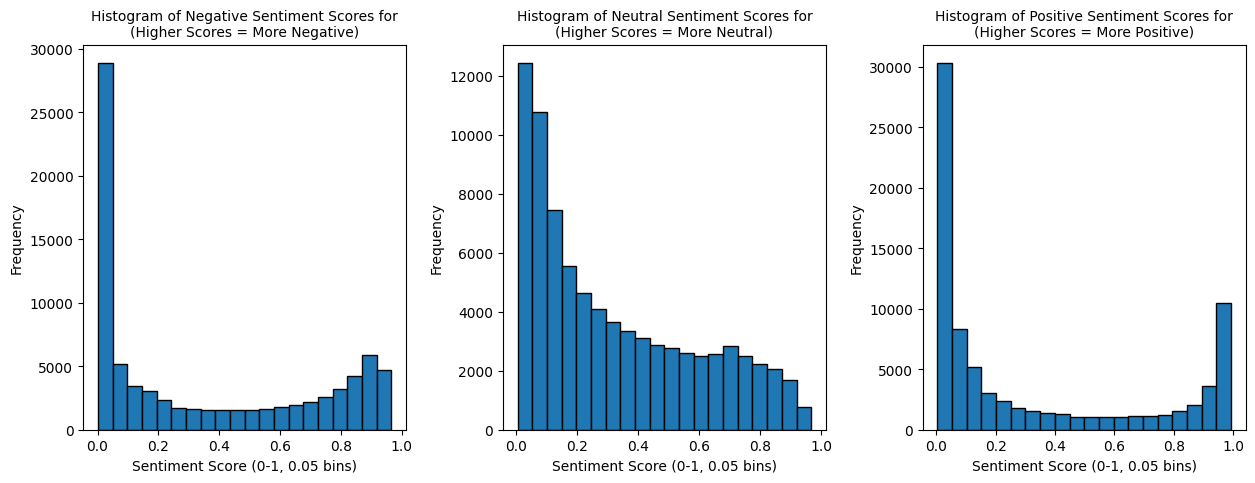

In [18]:
# Frequency distribution for positive, negative and neutral sentiments of tweets
# Note: this could be systematically skewed by the model used.

fig, axes = plt.subplots(1,3, figsize=(15,5))

sentiment_list = ['negative', 'neutral', 'positive']
for i, sentiment in enumerate(sentiment_list):
    axes[i].hist(sentiment_tweet_df_2020[sentiment], bins=20, edgecolor='black')
    axes[i].set_title(f'Histogram of {sentiment.capitalize()} Sentiment Scores for\n(Higher Scores = More {sentiment.capitalize()})', fontsize=10)
    axes[i].set_xlabel('Sentiment Score (0-1, 0.05 bins)')
    axes[i].set_ylabel('Frequency')


plt.subplots_adjust(wspace=0.3)
plt.show()

In [32]:
# Removing timezone info
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT * FROM all_2020_sentiment"
    sentiment_df_2020 = pd.read_sql(query, connection)
    sentiment_df_2020['created_at'] = pd.to_datetime(sentiment_df_2020['created_at']).dt.tz_localize(None)
    sentiment_df_2020.to_sql('all_2022_sentiment', connection,if_exists='replace', index=False)

In [40]:

# Get df with only created_at and sentiment.
with SQLContextManager('twitter_sentiment_analysis.db') as connection:
    query = "SELECT created_at, negative, neutral, positive FROM all_2020_sentiment"
    sentiment_df_2020 = pd.read_sql(query, connection)

sentiment_df_2020.head(5)

,created_at,negative,neutral,positive
0,Thu Dec 31 23:54:57 +0000 2020,0.1347,0.2309,0.6344
1,Thu Dec 31 23:53:50 +0000 2020,0.9351,0.0517,0.0132
2,Thu Dec 31 23:51:44 +0000 2020,0.0830,0.1847,0.7323
3,Thu Dec 31 23:46:21 +0000 2020,0.5482,0.1848,0.2670
4,Thu Dec 31 23:44:27 +0000 2020,0.9167,0.0709,0.0124


### Visualising How Sentiment Changes With Time For 2020

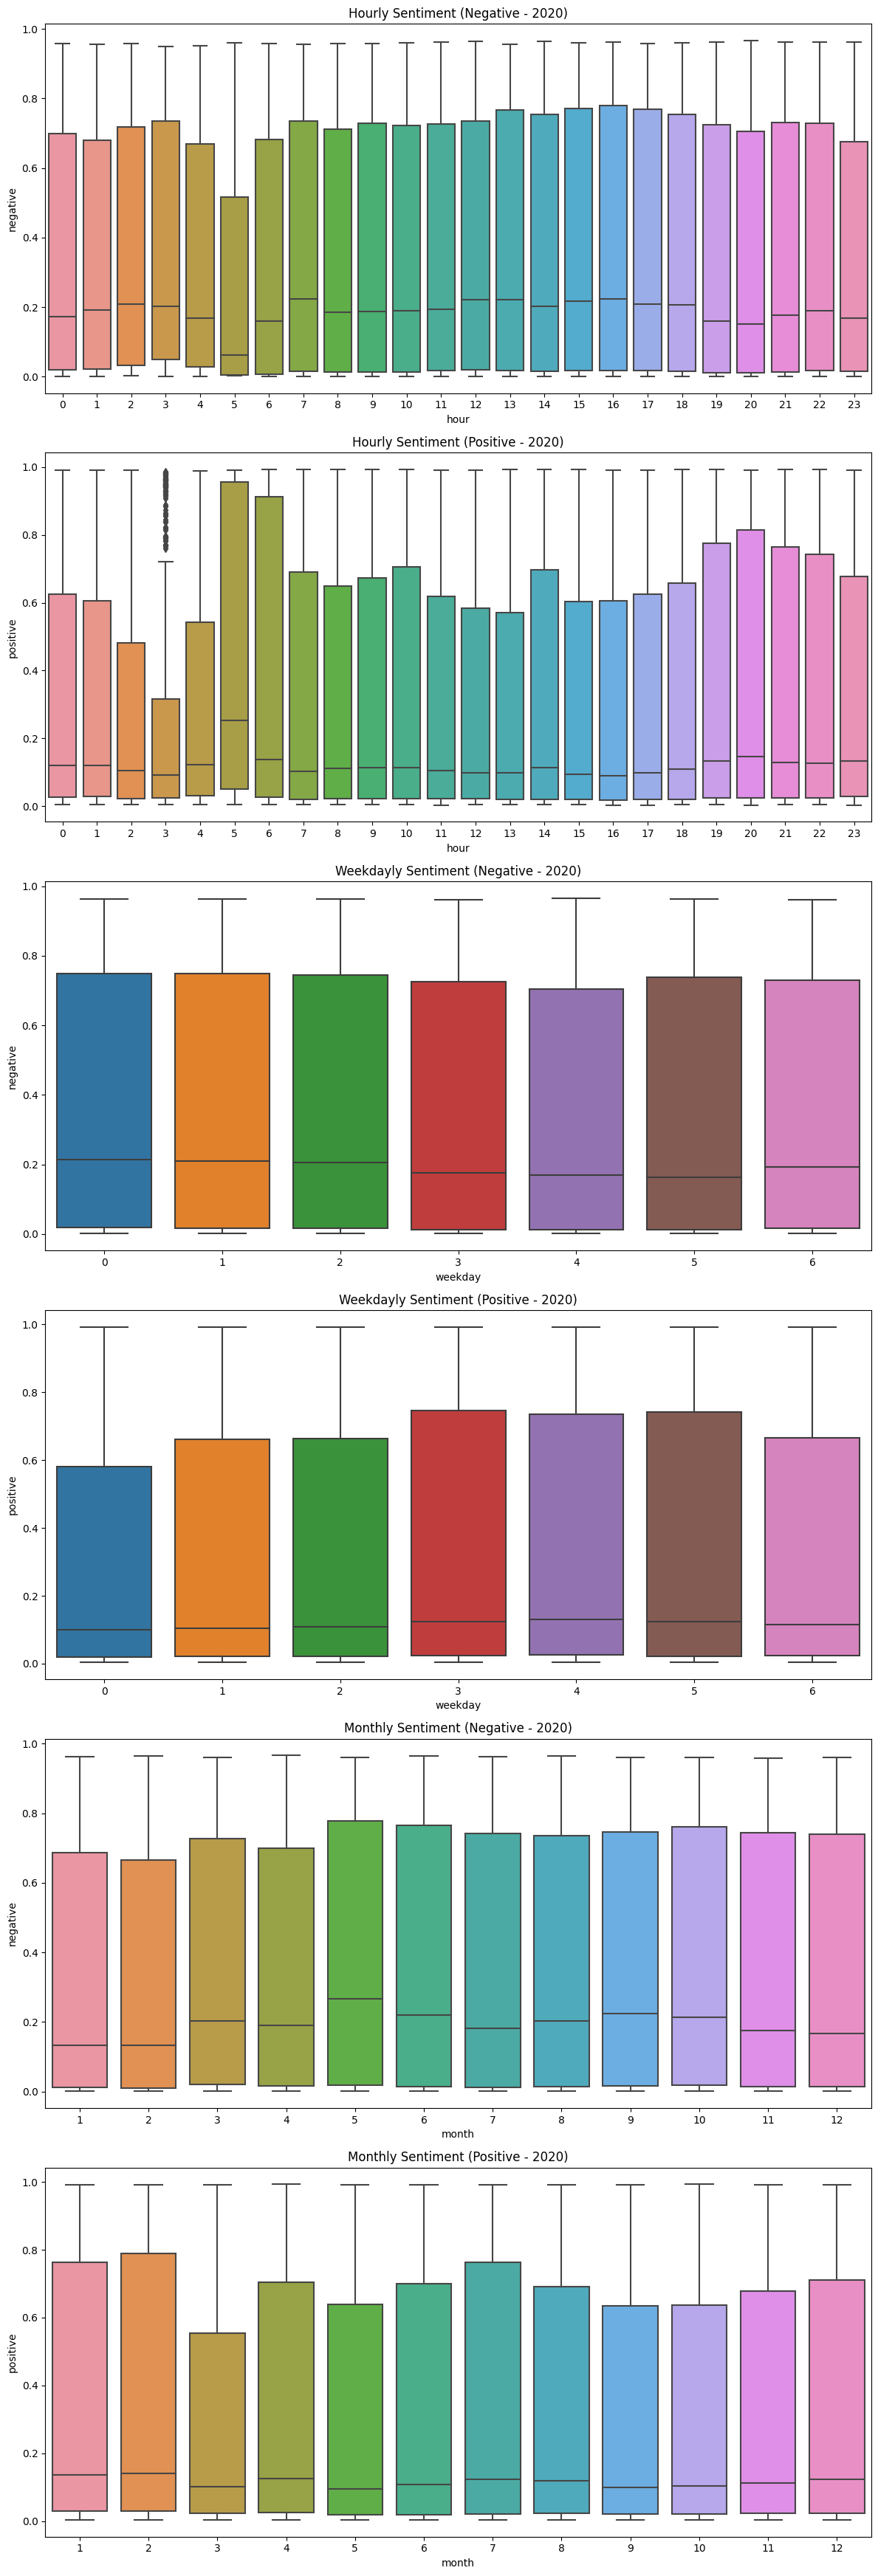

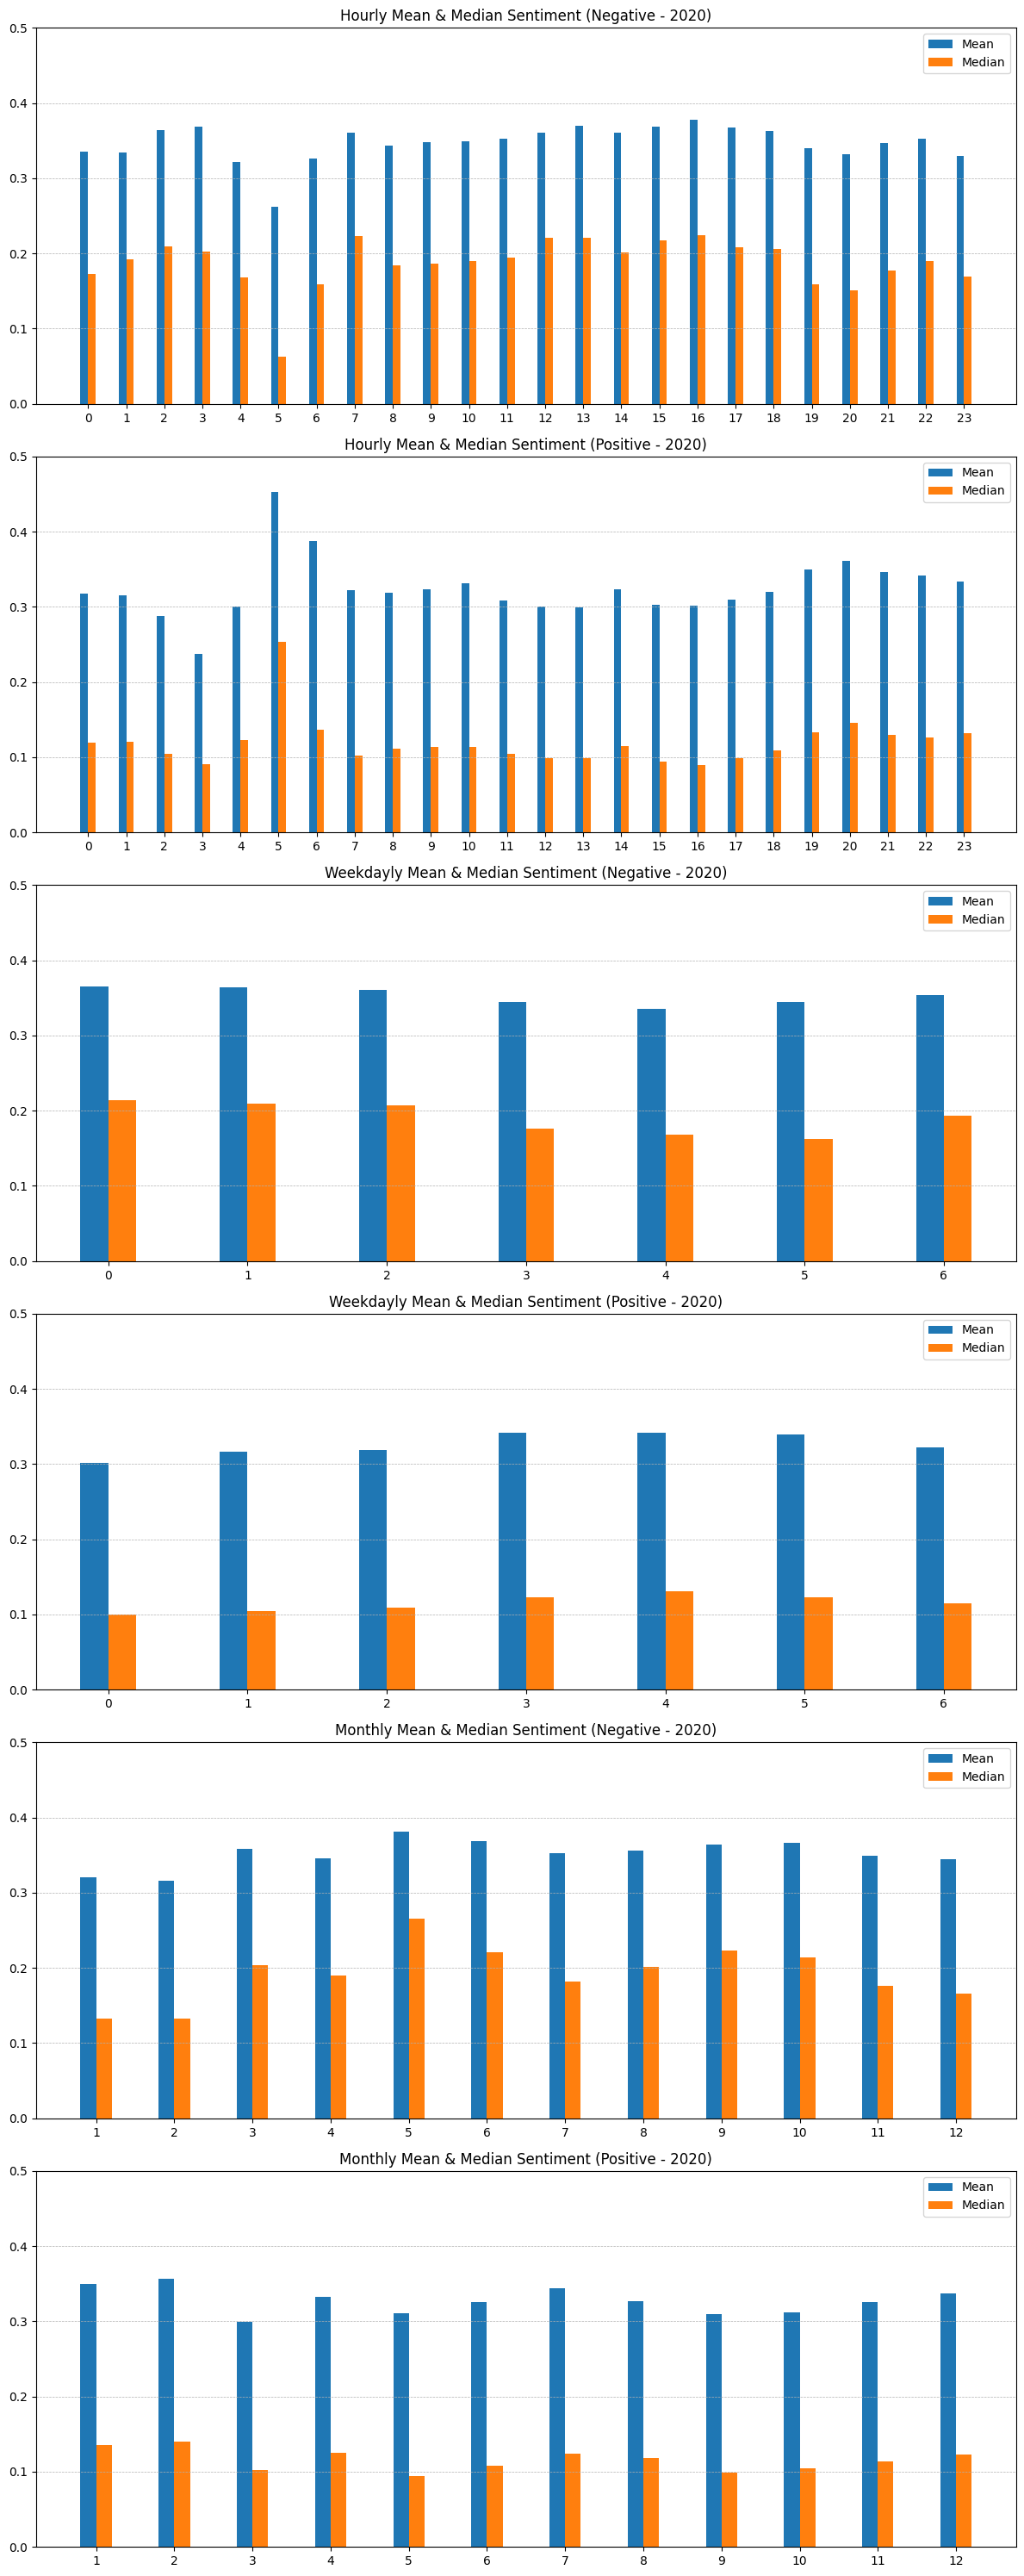

In [45]:
import numpy as np
import seaborn as sns
sentiment_df_2020['created_at'] = pd.to_datetime(sentiment_df_2020['created_at'])
sentiment_df_2020['hour'] = sentiment_df_2020['created_at'].dt.hour
sentiment_df_2020['weekday'] = sentiment_df_2020['created_at'].dt.weekday
sentiment_df_2020['month'] = sentiment_df_2020['created_at'].dt.month

fig, axes = plt.subplots(6,1,figsize=(12,35))

period_list = ['hour', 'weekday', 'month']
sentiment_list = ['negative', 'positive']

i = 0
for period in period_list:
    for sentiment in sentiment_list:
        sns.boxplot(x=period, y=sentiment, data=sentiment_df_2020, ax=axes[i])
        axes[i].set_title(f'{period.capitalize()}ly Sentiment ({sentiment.capitalize()} - 2020)')
        i += 1

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(6,1,figsize=(12,30))
i = 0 
for period in period_list:
    grouped_mean = sentiment_df_2020.groupby(period).mean(numeric_only=True)
    grouped_median = sentiment_df_2020.groupby(period).median(numeric_only=True)
    index = grouped_mean.index
    x = np.arange(len(index))
    width = 0.2
    for sentiment in sentiment_list:
        mean_values = grouped_mean[sentiment]
        median_values = grouped_median[sentiment]
        axes[i].bar(x - width/2, mean_values, width, label='Mean')
        axes[i].bar(x + width/2, median_values, width, label='Median')
        axes[i].set_title(f'{period.capitalize()}ly Mean & Median Sentiment ({sentiment.capitalize()} - 2020)')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(index)
        axes[i].yaxis.grid(True, linestyle='--', linewidth=0.5)
        axes[i].set_ylim(0.0,0.5)
        axes[i].legend()
        i += 1

plt.tight_layout()
plt.show()

##### I had expected to see an increase in positive sentiment in the summer months compared to the winter months. This does not appear to be the case when looking at the monthly boxplots or barcharts. 


##### There is an interesting jump in positive sentiment around 5am which is quite interesting. I will explore this below.

In [24]:
sentiment_df_2020
filtered_hour_only_df = sentiment_df_2020.drop(columns=['weekday', 'month', 'neutral'])

filtered_df_3_to_5_am = filtered_hour_only_df[filtered_hour_only_df['hour'].isin([3,4,5])]


print(f'Correlation between 3am and 5am:\n{filtered_df_3_to_5_am.corr(numeric_only=True)}\n')


Correlation between 3am and 5am:
          negative  positive      hour
negative  1.000000 -0.700216 -0.134266
positive -0.700216  1.000000  0.246861
hour     -0.134266  0.246861  1.000000



#####  There is an inverse correlation (-0.7) between positive and negative sentiment between 3am and 5am

### Calculating the normality and variance of sentiment between 3am and 5am

In [25]:
# Testing for normality 
from scipy.stats import shapiro
alpha = 0.05
sentiment_list = ['positive', 'negative']
period_list = [3,4,5]
for sentiment in sentiment_list:
    for period in period_list:
        df = filtered_hour_only_df[filtered_hour_only_df['hour'] == period]
        sentiment_data = df[sentiment]
        test_result = shapiro(sentiment_data)
        print(f'Shapiro-Wilk Test for {sentiment.capitalize()} sentiment at {str(period)} AM: ', test_result)
        if test_result.pvalue < alpha:
            print(f'{sentiment.capitalize()} Sentiment Data for {str(period)}am does not follow a normal distribution\n')
        else:
            print(f'{sentiment.capitalize()} Sentiment Data for {str(period)}am does follow a normal distribution.\n')




Shapiro-Wilk Test for Positive sentiment at 3 AM:  ShapiroResult(statistic=0.7311924695968628, pvalue=8.456143051187121e-28)
Positive Sentiment Data for 3am does not follow a normal distribution

Shapiro-Wilk Test for Positive sentiment at 4 AM:  ShapiroResult(statistic=0.7629300355911255, pvalue=1.1945825606262176e-23)
Positive Sentiment Data for 4am does not follow a normal distribution

Shapiro-Wilk Test for Positive sentiment at 5 AM:  ShapiroResult(statistic=0.7826024889945984, pvalue=1.3777326055479262e-30)
Positive Sentiment Data for 5am does not follow a normal distribution

Shapiro-Wilk Test for Negative sentiment at 3 AM:  ShapiroResult(statistic=0.8359497785568237, pvalue=1.8837573062877667e-22)
Negative Sentiment Data for 3am does not follow a normal distribution

Shapiro-Wilk Test for Negative sentiment at 4 AM:  ShapiroResult(statistic=0.8078887462615967, pvalue=1.6165692089216472e-21)
Negative Sentiment Data for 4am does not follow a normal distribution

Shapiro-Wilk Tes

In [27]:
# Calculating variance. 
sentiment_list = ['positive', 'negative']
period_list = [3,4,5]
for sentiment in sentiment_list:
    for period in period_list:
        df = filtered_hour_only_df[filtered_hour_only_df['hour'] == period]
        sentiment_data = df[sentiment]
        variance = np.var(sentiment_data, ddof=0)
        print(f'Variance for {sentiment} sentiment at {period}am is: {variance}')



Variance for positive sentiment at 3am is: 0.09290292636166647
Variance for positive sentiment at 4am is: 0.12190334683745452
Variance for positive sentiment at 5am is: 0.17184143587950138
Variance for negative sentiment at 3am is: 0.11916057330820193
Variance for negative sentiment at 4am is: 0.11397719899488874
Variance for negative sentiment at 5am is: 0.10900146248968144


### Visulaising the distribution of sentiment between 3am and 5am

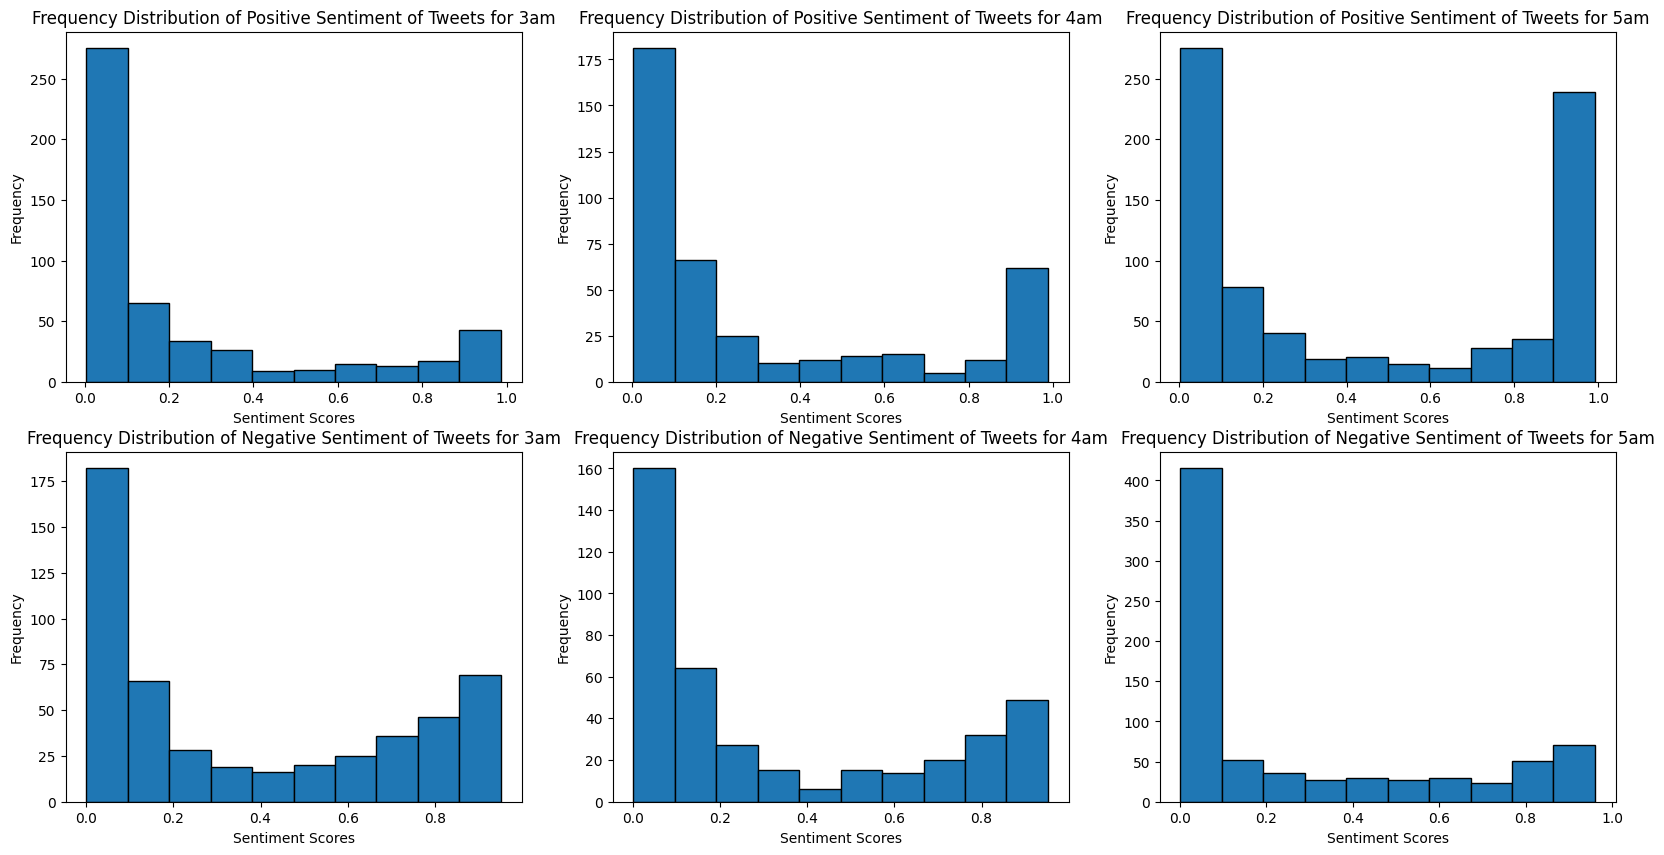

In [28]:

fig, axes = plt.subplots(2,3,figsize=(20,10))
sentiment_list = ['positive', 'negative']
period_list = [3,4,5]
i = 0

for row, sentiment in enumerate(sentiment_list):
    for col, period in enumerate(period_list):
        df = filtered_hour_only_df[filtered_hour_only_df['hour'] == period]
        axes[row, col].hist(df[sentiment], bins=10, edgecolor='black')
        axes[row, col].set_title(f'Frequency Distribution of {sentiment.capitalize()} Sentiment of Tweets for {str(period)}am')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_xlabel('Sentiment Scores')

### Testing for significance between the sentiment data for 3am, 4am and 5am

#### Significance testing using a Kruskal-Wallis H-test as the data is not normally distributed. 

In [29]:
from scipy.stats import kruskal

sentiment_3am = filtered_hour_only_df[filtered_hour_only_df['hour'] == 3]
sentiment_4am = filtered_hour_only_df[filtered_hour_only_df['hour'] == 4]
sentiment_5am = filtered_hour_only_df[filtered_hour_only_df['hour'] == 5]

for sentiment in sentiment_list:
    result = kruskal(sentiment_3am[sentiment], sentiment_4am[sentiment], sentiment_5am[sentiment])
    print(f'Kruskal-Wallis H-test result for {sentiment} sentiment: {result}')
    if result.pvalue < 0.05:
        print(f'There is a significant difference between the median {sentiment} sentiments of tweets between 3am, 4am and 5am.\n')
    else: 
        print(f'There is no significant difference between the median {sentiment} sentiments of tweets between 3am, 4am and 5am.\n')



Kruskal-Wallis H-test result for positive sentiment: KruskalResult(statistic=82.34276834059114, pvalue=1.316724882200847e-18)
There is a significant difference between the median positive sentiments of tweets between 3am, 4am and 5am.

Kruskal-Wallis H-test result for negative sentiment: KruskalResult(statistic=71.1447807767852, pvalue=3.5571906835943734e-16)
There is a significant difference between the median negative sentiments of tweets between 3am, 4am and 5am.



In [37]:
import scikit_posthocs as sp
sentiment_list = ['positive', 'negative']
for sentiment in sentiment_list:
    sentiment_data = filtered_hour_only_df[filtered_hour_only_df['hour'].isin([3, 4, 5])][['hour', sentiment]]

    dunn_result = sp.posthoc_dunn(sentiment_data, val_col=sentiment, group_col='hour', p_adjust='bonferroni')
    print(f"Dunn's test result for {sentiment} sentiment:\n{dunn_result}\n")
    

Dunn's test result for positive sentiment:
              3             4             5
3  1.000000e+00  3.248785e-02  5.010763e-18
4  3.248785e-02  1.000000e+00  1.975673e-07
5  5.010763e-18  1.975673e-07  1.000000e+00

Dunn's test result for negative sentiment:
              3             4             5
3  1.000000e+00  1.109447e-01  1.947541e-15
4  1.109447e-01  1.000000e+00  4.471186e-07
5  1.947541e-15  4.471186e-07  1.000000e+00



### Conclusions - Sentiment of Tweets Between 3am and 5am. 

Positive Sentiment:
Hour 3am vs Hour 4am: p-value = 0.0325. This indicates a statistically significant difference between the two groups, as the p-value is less than 0.05.
Hour 4am vs Hour 5am: p-value = 1.98e-07. This also indicates a highly statistically significant difference between the two groups, as the p-value is much less than 0.05.

Negative Sentiment: 
Hour 3am vs Hour 4am: p-value = 0.1109. This indicates no statistically significant difference between the two groups, as the p-value is greater than 0.05.
Hour 4am vs Hour 5am: p-value = 4.47e-07. This also indicates a highly statistically significant difference between the two groups, as the p-value is much less than 0.05.

In conclusion, there is a significant shift in sentiment between tweets created between 4am and 5am, increasing in positivity and decreasing in negativity. 